In [59]:
! pip install stop-words

## Settings and configs

In [1]:
import nltk
#nltk.download() # uncomment to download stopwords
from nltk.corpus import stopwords   
from stop_words import safe_get_stop_words

In [2]:
mapping = {'en':
           {'dataset_file': 'data/dataset_en.csv',
            'model_file': 'models/model_en.pickle',
            'language_regex': '[^a-z]',
            'stop_words': set(stopwords.words('english')),
            'dataset_size': 2500,
            'text_column': 'Text',
            'summaries_column': 'Summary'},
           'ua':
           {'dataset_file': 'data/dataset_ua.csv',
            'model_file': 'models/model_ua.pickle',
            'language_regex': '[^йцукенгшщзхфвапролджячсмитьбюїіє]',
            'stop_words': set(safe_get_stop_words('ukrainian')),
            'dataset_size': 2500,
            'text_column': 'text',
            'summaries_column': 'title'}
          }

In [3]:
# useful only for english
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                       "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                       "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                       "you're": "you are", "you've": "you have"}

In [4]:
LANG = 'ua'

## Collect single csv

In [5]:
import os
import pandas
import ujson
from pathlib import Path
from random import shuffle

In [6]:
jsons_dir = Path('/home/bogdan/Research/TextSummarization/NAMAS/ukr_dataset')

In [7]:
def merge_jsons_to_csv(jsons_dir):
    with open(mapping[LANG]['dataset_file'],'w') as f:
        f.write(f'{mapping[LANG]["summaries_column"]},alternative_{mapping[LANG]["summaries_column"]},{mapping[LANG]["text_column"]}\n')
        for file_path in os.listdir(jsons_dir):
            batch = ujson.load(open(jsons_dir / file_path, 'r'))
            for line in batch:
                title = line['title'].replace(',','')
                alternative_title = title.split()
                shuffle(alternative_title)
                alternative_title = ' '.join(alternative_title)
                text = line['text'].replace(',','')
                #date = line['date']
                f.write(title+','+alternative_title+','+text+'\n')

In [32]:
base_dir = Path('/home/bogdan/Research/textsummarizationwithclustering/')
if not os.path.isfile(base_dir / mapping[LANG]['dataset_file']):
    merge_jsons_to_csv(jsons_dir)

--------------------------------

In [9]:
import numpy as np  
import pandas as pd 
import re
from attention import AttentionLayer
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

## Read and clean data

In [10]:
data = pd.read_csv(mapping[LANG]['dataset_file'],
                   nrows=mapping[LANG]['dataset_size'])

In [11]:
data.shape

(2500, 3)

In [12]:
data.head(1)

title  \
0  Порошенко звернувся до українців напередодні Дня пам'яті жертв голодоморів   

                                                            alternative_title  \
0  напередодні звернувся українців пам'яті до Порошенко Дня голодоморів жертв   

                                                                                                                                                                                                      text  
0  Президент Петро Порошенко закликав українців у всьому світі не забувати про Голодомор-геноцид та інші злочини радянського тоталітарного режиму проти українського народу. У зверненні з нагоди Дня п...

In [13]:
data.drop_duplicates(subset=[mapping[LANG]['text_column']],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)

In [14]:
data[mapping[LANG]['text_column']][:5]

0    Президент Петро Порошенко закликав українців у всьому світі не забувати про Голодомор-геноцид та інші злочини радянського тоталітарного режиму проти українського народу. У зверненні з нагоди Дня п...
1    Президент Петро Порошенко в п'ятницю 23 листопада задекларував 60 млн грн (10 млн до 50 млн) дивідендів що надійшли від Фонду Прайм Ессетс Капітал. Про це з посиланням на прес-службу адміністрації...
2    Львівські перевізники відмовилися перевозити безкоштовно пільгові категорії громадян зокрема пенсіонерів поки їм не гарантують з держбюджету компенсацію в розмірі 85 мільйонів гривень в рік. Також...
3    Українська політв'язень Павло Гриб викрадений російськими спецслужбами на території Білорусі не отримує кореспонденцію повідомив його батько Ігор Гриб."Сьогодні 23 листопада пройшло чергове судове...
4    У столиці бюджет порівняно з 2018 роком збільшиться на чотири мільярди гривень і складе 53 мільярди гривень. Про це повідомив мер столиці Віталій Кличко передає його прес-служ

In [15]:
def text_cleaner(text):
    newString = text.lower()
    if LANG == 'en':
        newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = re.sub("''",'', newString)
    if LANG == 'en':
        newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub(mapping[LANG]['language_regex'], " ", newString) 
    tokens = [w for w in newString.split() if not w in mapping[LANG]['stop_words']]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data[mapping[LANG]['text_column']]:
    cleaned_text.append(text_cleaner(t))

In [16]:
data[mapping[LANG]['summaries_column']][:5]

0    Порошенко звернувся до українців напередодні Дня пам'яті жертв голодоморів
1                                  Порошенко задекларував 60 млн грн дивідендів
2    У Львові приватні перевізники відмовляються безкоштовно возити пенсіонерів
3                                   Політв'язень Гриб перестав отримувати листи
4                                     Борги столиці скоротилися до 12 мільярдів
Name: title, dtype: object

In [17]:
def summary_cleaner(text):
    newString = text.lower()
    newString = re.sub('"','', newString)
    newString = re.sub("''",'', newString)
    if LANG == 'en':
        newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub(mapping[LANG]['language_regex'], " ", newString)
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

cleaned_title = []
for t in data[mapping[LANG]['summaries_column']]:
    cleaned_title.append(summary_cleaner(t))

cleaned_alternative_title = []
for t in data[f'alternative_{mapping[LANG]["summaries_column"]}']:
    cleaned_alternative_title.append(summary_cleaner(t))

In [18]:
data[f'cleaned_{mapping[LANG]["text_column"]}']=cleaned_text
data[f'cleaned_{mapping[LANG]["summaries_column"]}']=cleaned_title
data[f'cleaned_{mapping[LANG]["summaries_column"]}'].replace('', np.nan, inplace=True)
data[f'cleaned_alternative_{mapping[LANG]["summaries_column"]}']=cleaned_alternative_title
data[f'cleaned_alternative_{mapping[LANG]["summaries_column"]}'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [19]:
data[f'cleaned_{mapping[LANG]["summaries_column"]}'] = data[f'cleaned_{mapping[LANG]["summaries_column"]}'].apply(lambda x : '_START_ '+ x + ' _END_')

In [20]:
for i in range(1):
    print("Review:",data[f'cleaned_{mapping[LANG]["text_column"]}'][i])
    print("Title:",data[f'cleaned_{mapping[LANG]["summaries_column"]}'][i])
    print("Alternative Title:",data[f'cleaned_alternative_{mapping[LANG]["summaries_column"]}'][i])
    print("\n")

Review: президент петро порошенко закликав українців світі забувати голодомор геноцид злочини радянського тоталітарного режиму українського народу зверненні нагоди дня пам яті жертв голодоморів річниці голодомору глава держави підкреслив терор голодом свідомою політикою більшовиків вагомий привід згадати осмислити великі трагедії минулого століття згадати молитві невинних жертв спонукає подивитися прямо очі жахливу правду голодомори україні штучними скоєними людьми людей точніше нелюдами людей заявив порошенко президент констатував голодомори депортації політичні репресії повний перелік злочинів комуністичного режиму україни збереження україни повинні пам ятати вірю мільйони невинно загублених душ змогли знайти вічний спокій десятиліття замовчування неприємних системи історичних фактів залишилися радянському минулому залізною завісою висловив упевненість глава держави порошенко зазначив цивілізований світ листопада разом українцями згадує жертв геноциду українського народу радянським т

### Cleaned texts and summaries analysis

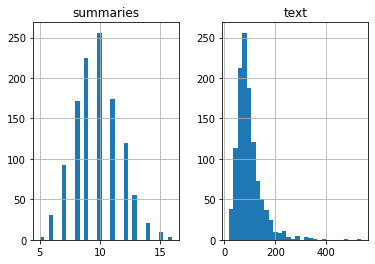

In [21]:
import matplotlib.pyplot as plt
text_word_count = []
summaries_word_count = []

# populate the lists with sentence lengths
for i in data[f'cleaned_{mapping[LANG]["text_column"]}']:
      text_word_count.append(len(i.split()))

for i in data[f'cleaned_{mapping[LANG]["summaries_column"]}']:
      summaries_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summaries':summaries_word_count})
length_df.hist(bins = 30)
plt.show()

In [22]:
max_len_text=200 
max_len_summaries=15

In [23]:
valid_train_samples_fraction = length_df[(length_df['text'] <= max_len_text)&(length_df['summaries'] <= max_len_summaries)].shape[0] / data.shape[0]
valid_train_samples_fraction

0.9612403100775194

### Split dataset, prepare tokenizers, pad sequences

In [24]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data[f'cleaned_{mapping[LANG]["text_column"]}'],data[f'cleaned_{mapping[LANG]["summaries_column"]}'],test_size=0.1,random_state=0,shuffle=True)

In [25]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [26]:
x_tr.shape

(1044, 200)

In [27]:
x_val.shape

(117, 200)

In [28]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summaries, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summaries, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

### Models

In [29]:
from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 500)     12980500    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [30]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

### Training

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/5


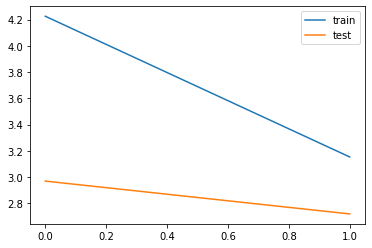

In [48]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

### Inference

In [49]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [50]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [67]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    print('e_out :', e_out)
    print('e_h :', e_h)
    print('e_c :', e_c)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        print(sampled_token)

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [52]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [68]:
for i in range(len(x_val)):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print(x_val[i].reshape(1,max_len_text))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    print("\n")

Review: energy chews absolutely delicious hold really well pocket backpack backpacking mountain biking really could imagine eating energy chew ever 
Original summary: love these energy chews 
[[ 309 1645  291   71  998   11   29 1707 5115 9342  621 8163   11   38
  1164  130  309  687   96    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]
e_out : [[[ 2.7556503e-03 -3.1716540e-03 -2.6469242e-03 ... -2.8209391e-03
   -2.8331878e-03 -4.8030948e-04]
  [ 6.9534420e-03 -8.6153373e-03 -7.5831795e-03 ... -7.7757547e-03
   -7.9394272e-03 -1.1456031e-03]
  [ 1.3171098e-02 -1.7581269e-02 -1.6241960e-02 ... -1.5719535e-02
   -1.6645078e-02 -2.2875695e-03]
  ...
  [ 7.0142889e-01 -9.1824007e-01 -7.7192682e-01 ... -8.8866115e-01
   -7.8252

great
end


KeyError: 0